# Inversion of sea surface currents from satellite-derived SST-SSH synergies with 4DVarNets

This notebook presents the evaluation of the sea surface currents (SSC) reconstruction based on the 4DVarNet approach ([Fablet et al., 2022](https://arxiv.org/abs/2211.13059)).

It is structured as follow:

1. Methodology
2. Reading of reference and reconstructed SSC fields
3. Evaluating the reconstructed SSC field
4. Visualisation

We will use the following modules in this notebook:

In [1]:
import pandas as pd
import xarray as xr

from src.metrics import psd_based_scores, rmse_based_scores, var_based_scores
from src.plot import plot_psd_score

## 1. Methodology

Given a reference SSC field (`ref`), two reconstructions are compared. The first reconstruction (`rec_A`) includes the sea surface temperature (SST) data in the learning process whilst the second reconstruction (`rec_B`) does not use SST.

The evaluations are based on the methods & metrics used in the [_2020a SSH mapping NATL60_](https://github.com/ocean-data-challenges/2020a_SSH_mapping_NATL60#baseline-and-evaluation) ocean data challenge. It includes a statistical and spectral analysis between `rec_{A|B}` and `ref`.

### Statistical analysis

The reconstruction is evaluated with the following metric, given a time $t$:

$$
    RMSE_{\text{ref}, \text{rec}}(t) =
        1 - \frac{RMSE(\text{rec}(t))}{RMS(\text{ref}(t))}
$$

Where $RMSE$ is the root mean square error, $RMS$ is the root mean square and $\text{ref}(t)$ (resp. $\text{rec}(t)$) is the reference (resp. reconstructed) SSC field at time $t$.

The metric $RMSE_{\text{ref}, \text{rec}}$ is calculated for each time $t_0, t_1, ..., t_n$. Then, we deduce the mean score $\mu$ and the standard deviation $\sigma$. This latter gives an insight on the temporal stability of the reconstruction.

In addition to the previous metric, the reconstruction performance is also 
evaluated in terms of explained variance:

- $\tau_{u,v}$ : explained variance of the reconstructed SSC
- $\tau_{\text{vort}}$ : explained variance of the vorticity of the
    reconstructed SSC
- $\tau_{\text{div}}$ : explained variance of the divergence of the
    reconstructed SSC
- $\tau_{\text{strain}}$ : explained variance of the strain of the reconstructed
    SSC

### Spectral analysis

The metric used here is the power spectral density, based on the wavenumber frequency. It is defined as follow:

$$
    PSD_{\text{ref}, \text{rec}} = 1 - \frac{PSD(\text{rec} - \text{ref})}{PSD(\text{ref})}
$$

From this spectral analysis, the following scores can be derived:

- $\lambda_t$ : the minimum time scale resolved in days for the SSH reconstruction
- $\lambda_x$ : the minimum spatial scale resolved in degrees for the SSH reconstruction
- $\lambda_{t,u}$ and $\lambda_{t,v}$ : same as $\lambda_t$ but for the zonal and meridional velocities
- $\lambda_{x,u}$ and $\lambda_{x,v}$ : same as $\lambda_x$ but for the zonal and meridional velocities

## 2. Reading of reference and reconstructed SSC fields

The data (`ref`, `rec_A` and `rec_B`) are located in the `./data/` directory in netCDF4 format. The variables contained in these data are the sea surface height (SSH), the sea surface temperature (SST) for `rec_A`, the zonal velocity $u$ et the meridional velocity $v$.

Note that both data are already on the same grid.

In [2]:
# Paths to the netCDF files
paths = {
    'ref': 'data/ref.nc',
    'rec_w_sst': 'data/rec_w_sst.nc',
    'rec_wo_sst': 'data/rec_wo_sst.nc',  # To update
}

In [3]:
# Retrieving reference SSC field
ref = xr.open_dataset(paths['ref'])
ref

<xarray.Dataset>
Dimensions:  (time: 43, lat: 200, lon: 200, feat: 1)
Coordinates:
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-03T12:00:00
  * feat     (feat) int64 0
Data variables:
    ssh      (time, lat, lon) float64 ...
    sst      (time, feat, lat, lon) float32 ...
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...

In [4]:
# Retrieving reconstructed SSC field with SST
rec_w_sst = xr.open_dataset(paths['rec_w_sst'])
rec_w_sst

<xarray.Dataset>
Dimensions:  (time: 43, lat: 200, lon: 200, feat: 1)
Coordinates:
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-03T12:00:00
  * feat     (feat) int64 0
Data variables:
    ssh      (time, lat, lon) float64 ...
    sst      (time, feat, lat, lon) float32 ...
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...

In [5]:
# Retrieving reconstructed SSC field without SST
rec_wo_sst = xr.open_dataset(paths['rec_wo_sst'])
rec_wo_sst

<xarray.Dataset>
Dimensions:  (time: 43, lat: 200, lon: 200)
Coordinates:
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.8 42.85 42.9 42.95
  * time     (time) datetime64[ns] 2012-10-22T12:00:00 ... 2012-12-03T12:00:00
Data variables:
    ssh      (time, lat, lon) float64 ...
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...

## 3. Evaluating the reconstructed SSC field

Evaluating the reconstructed SSC field requires to compute the scores of the SSH, $u$ and $v$ of each field.

In [6]:
scores_w_sst, scores_wo_sst = {}, {}

### A. Reconstruction with SST

In [7]:
# SSH scores
rmse_A, rmse_mu, rmse_sigma = rmse_based_scores(rec_w_sst.ssh, ref.ssh)
tau_uv, tau_vort, tau_div, tau_strain = var_based_scores(rec_w_sst, ref)
psd_A, lambda_x, lambda_t = psd_based_scores(rec_w_sst.ssh, ref.ssh)

scores_w_sst['µ'] = rmse_mu
scores_w_sst['σ'] = rmse_sigma
scores_w_sst['λ_x'] = lambda_x
scores_w_sst['λ_t'] = lambda_t

In [8]:
# u scores
lambda_xu, lambda_tu = psd_based_scores(rec_w_sst.u, ref.u)[1:]

scores_w_sst['λ_{x,u}'] = lambda_xu
scores_w_sst['λ_{t,u}'] = lambda_tu

In [9]:
# v scores
lambda_xv, lambda_tv = psd_based_scores(rec_w_sst.v, ref.v)[1:]

scores_w_sst['λ_{x,v}'] = lambda_xv
scores_w_sst['λ_{t,v}'] = lambda_tv

In [10]:
# Append the explainable variances to the scores
scores_w_sst['τ_{u,v}'] = tau_uv
scores_w_sst['τ_vort'] = tau_vort
scores_w_sst['τ_div'] = tau_div
scores_w_sst['τ_strain'] = tau_strain

### B. Reconstruction without SST

In [11]:
# SSH scores
rmse_B, rmse_mu, rmse_sigma = rmse_based_scores(rec_wo_sst.ssh, ref.ssh)
tau_uv, tau_vort, tau_div, tau_strain = var_based_scores(rec_wo_sst, ref)
psd_B, lambda_x, lambda_t = psd_based_scores(rec_wo_sst.ssh, ref.ssh)

scores_wo_sst['µ'] = rmse_mu
scores_wo_sst['σ'] = rmse_sigma
scores_wo_sst['λ_x'] = lambda_x
scores_wo_sst['λ_t'] = lambda_t

In [12]:
# u scores
lambda_xu, lambda_tu = psd_based_scores(rec_wo_sst.u, ref.u)[1:]

scores_wo_sst['λ_{x,u}'] = lambda_xu
scores_wo_sst['λ_{t,u}'] = lambda_tu

In [13]:
# v scores
lambda_xv, lambda_tv = psd_based_scores(rec_wo_sst.v, ref.v)[1:]

scores_wo_sst['λ_{x,v}'] = lambda_xv
scores_wo_sst['λ_{t,v}'] = lambda_tv

In [14]:
# Append the explainable variances to the scores
scores_wo_sst['τ_{u,v}'] = tau_uv
scores_wo_sst['τ_vort'] = tau_vort
scores_wo_sst['τ_div'] = tau_div
scores_wo_sst['τ_strain'] = tau_strain

### C. Comparison between the reconstructions

We can now compare the scores from these two experiments:

In [15]:
# Print the scores
pd.DataFrame(
    data=[scores_w_sst, scores_wo_sst],
    index=['With SST', 'Without SST'],
).T

,With SST,Without SST
µ,0.96797,0.95841
σ,0.00593,0.00978
λ_x,0.53551,0.65725
λ_t,2.50504,4.99289
"λ_{x,u}",0.77468,0.88091
"λ_{t,u}",2.67828,4.18554
"λ_{x,v}",0.57794,0.67734
"λ_{t,v}",2.88667,5.68036
"τ_{u,v}",97.35497,94.01925
τ_vort,NaN,NaN


## 4. Visualisation

RMSE comparisons:

In [16]:
# En cours

PSD comparisons:

In [17]:
psd_concat = xr.concat((psd_A, psd_B), dim='experiment')
psd_concat['experiment'] = ['With SST', 'Without SST']

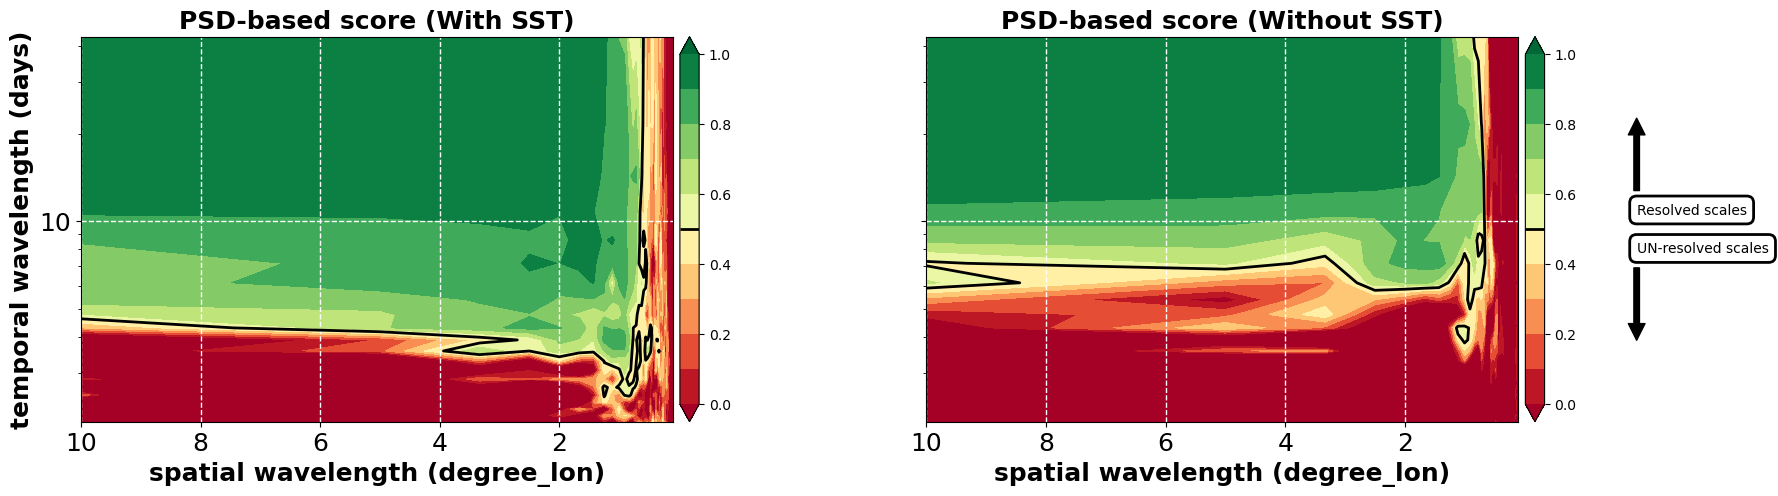

In [18]:
plot_psd_score(psd_concat)

Animations:

Notes du 9 novembre 2022 :
> - animation du modèle UV : il faudrait que l'on ait
>    - 1,1 u2 v2 gt
>    - 1,2 obs
>    - 2,1 reconstruction des courants avec "u_OI" (géostrophique)
>    - 2,2 u2 v2 rec

À faire

<img src="results/animation.gif" alt="animation">